<h1><center><b></b></center></h1>
<h1><center><b>JAM network</b></center></h1>
<h2><center><i> Not the usual jam 🥫 but ... a KAN-based Deep Neural Network for Pneumonia Detection  </i></center></h2>
<h3><center><i>By Jacopo And Massimo </i></center></h3>

<center>
Pneumonia is one of the most dangerous chest disease, especially among childs [1]

In our project, we have developed a single-disease [CAD](https://it.wikipedia.org/wiki/Computer-aided_design) system based on a deep-learning architecture that helps and make automatic the classification of pneumonia disease.

State-of-the-art [CAD](https://it.wikipedia.org/wiki/Computer-aided_design) system for pneumonia detection is explained in [FA-Net: A Fuzzy Attention-aided Deep Neural
Network for Pneumonia Detection in Chest X-Rays](https://arxiv.org/pdf/2406.15117) [1] and our aim was to study the performance of the newest architectur  [KAN: Kolmogorov-Arnold Networks](https://arxiv.org/pdf/2404.19756) [2]
in detection task

**You will find deeper information about the architecture into the `Dataset and Network classes` block**
</center>

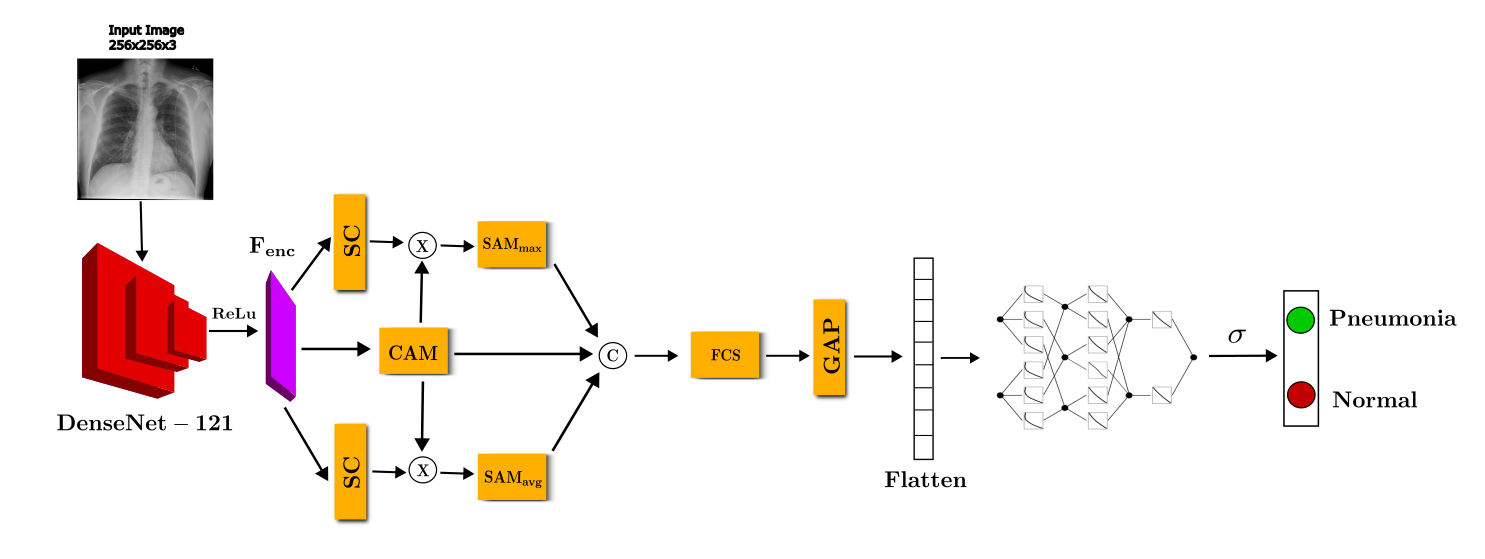



# Initialization
Installation of required libraries and setup of the enviroment and hyperparameters.

Here we can find:
* Installation of required libraries
* Hyperapameters: store in a dictionary called ```global_var```


* Device to be used during training
* Seeding to ensure reproducibility

<br>

Version used when running notebook

* gdown: 5.1.0
* tqdm: 4.66.4
* torchmetrics: 1.4.0.post0
* scikit-learn: Version: 1.2.2*
* pykan: 0.1.1

### Installation

In [ ]:
%%capture
!pip install gdown
!pip install tqdm
!pip install torchvision --quiet
!pip install pykan==0.1.1
!pip install torchmetrics
!pip install scikit-learn

In [ ]:
#!pip show gdown | sed -n '1,2p'
#!pip show tqdm | sed -n '1,2p'
#!pip show torchvision --quiet | sed -n '1,2p'
#!pip show torchmetrics | sed -n '1,2p'
#!pip show scikit-learn | sed -n '1,2p'
#pip show pykan | sed -n '1,2p'

### Import of libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import ToPILImage
from torchvision.io import read_image
from torch.utils.data import random_split, DataLoader, Dataset

from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import BinaryPrecision
from torchmetrics.classification import BinaryRecall
from torchmetrics.classification import BinaryAUROC
from torchmetrics.classification import BinaryF1Score

from kan import MultKAN as KAN

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

import os
import gdown
import zipfile
import shutil
import gc
from tqdm.notebook import tqdm
import time
from google.colab import drive
import json

import random


### GLOBAL DEFINITIONS

Global variables where there are stored hyperparameters for the training and link, paths for the dataset.

In [ ]:
global_var = {
    # Dataset
    'link_download_prefix' : 'https://drive.google.com/uc?export=download&id=YOUR_FILE_ID', # Generic link to download from Drive the file with id "YOUR_FILE_ID"
    "link_dataset": "https://drive.google.com/file/d/10un_W7teXQy9LOB1uqd0e6VJ46UFNRza/view?usp=drive_link0", # The ID is "10un_W7teXQy9LOB1uqd0e6VJ46UFNRza" of the file
    "path_download_dataset": "/content/dataset.zip", # Path of the runtime directory of Colab with the zipped dataset
    "extract_directory": "/content", # Directory where we want to extract the zipped dataset
    "dataset_name": "chest_xray", # Name of the dataset
    "dataset_name_resized": "chest_xray_resized", # Name of the dataset resized
    "dataset_name_resized_augmented": "chest_xray_resized_augmented", # Name of the dataset resized
    "dataset_name_heatmap": "chest_xray_heatmap",
    "dataset_name_gaussian": "chest_xray_gaussian",
    "dataset_name_gaussian_he": "chest_xray_gaussian_he",

    # Preprocessing parameters
    "resizing_dim": (256,256),
    "colormap_type": cv2.COLORMAP_TWILIGHT,
    "smoothing_value": 5,

    # Train
    'batch_size': 48,
    "train_epochs": 50,

    # logger parameters
    "log_directory": "/content/log_plots",

}

In [ ]:
seed = 0

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [ ]:
# Set the environment variable for deterministic CuBLAS operations
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Enable deterministic algorithms in PyTorch
torch.use_deterministic_algorithms(False)
# torch.backends.cudnn.benchmark = False # maybe cancell warning: UserWarning: Plan failed with a cudnnException, not tested

device = "cuda:0" if torch.cuda.is_available() else "cpu"

### Color Class
This class is used for printing text in different color. In particular each attribute in the Color class corresponds to a specific text color or formatting style.

In [ ]:
class Color:
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    MAGENTA = '\033[95m'
    CYAN = '\033[96m'
    WHITE = '\033[97m'
    RESET = '\033[0m' #RESET: Resets all text formatting and color to default
    BOLD = '\033[1m' #BOLD: Makes the text bold
    UNDERLINE = '\033[4m' #UNDERLINE: Underlines the text

Random Seed

# Dataset Setup
Operation to download thedataset and rearrange it for the usage.

## Initial setup


The function, given the link of the dataset in google drive, download it.

Args:
        
1.   **link_dataset** = link to zip files
2.   **delete_zip_file** = {True/False}, use to remove the zip file once extracted the content

Note: the link my be public or gdown can't download it


In [ ]:
def download_dataset(link_dataset, delete_zip_file=False):

    # Creating string for download

    link_download_base =  global_var['link_download_prefix'] # General link for the download from Drive (with "YOUR_FILE_ID")
    id_dataset = link_dataset.split("/view")[0].split("/")[-1]
    dataset_download_link = link_download_base.replace("YOUR_FILE_ID", id_dataset) # Replace the "YOUR_FILE_ID" part with the extracted id_dataset

    path_download_dataset = global_var['path_download_dataset'] # Path of the zip file that contain the dataset
    dataset_name = global_var['dataset_name'] # Dataset's Name
    extract_directory = global_var['extract_directory'] # Directory of the GColab Runtime where we want to extract the dataset

    # Downloading zip file
    try:
        if not( os.path.exists(dataset_name) ): # check is the dataset is already downloaded
            gdown.download(
                url=dataset_download_link, # Link that we extract with the file ID
                output=path_download_dataset, # Path of the runtime Colab to save the zip file
                quiet=False # Output to check the download
            )
            print(f"{Color.GREEN}\nZip file downloaded{Color.RESET}")
        else:
            print(f"{Color.GREEN}Zip file already downloaded{Color.RESET} ")
    except Exception as error:
        print(f"{Color.RED}Download went wrong!\nerror:{Color.RESET}")
        print(error)


    # Unzipping the file
    '''
    In this part we want to unzip the zip file contain the dataset
    '''
    try:
        if not( os.path.exists(dataset_name) ):

          # This open the file zip in path_download_dataset in 'r' = read mode.
          # The file is created from the ZipFile class contained in zipfile module
          # and the name of the instance will be zipfile

            with zipfile.ZipFile(path_download_dataset, 'r') as zip_file:

                n_files = len(zip_file.namelist()) # number of files and directories inside the zip

                with tqdm(total=n_files, desc='Unzipping files') as pbar: # It's a bar to track the unzip process, we pass the number of total files
                    for file_name in zip_file.namelist():
                        zip_file.extract(member=file_name, path=extract_directory) # Extract the file_name (iteration over all the files) in the path extract_directory
                        pbar.update(1) # increment the progress bar of 1 unit for each extraction

            print(f"{Color.GREEN}Dataset {dataset_name} unzipped{Color.RESET}")
        else:
            print(f"{Color.GREEN}Dataset {dataset_name} already unzipped{Color.RESET} ")
    except Exception as error:
        print(f"{Color.RED}Unzip went wrong!\nerror:{Color.RESET}")
        print(error)

    # Removing zip file
    '''
    In this part we remove the zip file if the flag
    delete_zip_file is True (args of the function)
    '''
    try:
        if delete_zip_file == True:
            ! rm {path_download_dataset}
            print(f"{Color.GREEN}File {path_download_dataset} removed{Color.RESET}")
    except Exception as error:
        print(f"{Color.RED}Could not remove zip file, pass!\nerror:{Color.RESET}")
        print(error)
        pass

Given the dataset, it merge and shuffle it.

In [ ]:
def merge_dataset():

    dataset_name = global_var['dataset_name'] # Name of the directory
    extract_directory = global_var['extract_directory'] # Directory of destination where we put the shuffled dataset
    current_path = os.path.join(extract_directory, dataset_name) # Create the path "/content/chest_xray"
    origin_dataset = os.path.join(current_path,dataset_name) # Create the path "/content/chest_xray/chest_xray"

    # Create a list of this type -> ['/content/chest_xray/train', '/content/chest_xray/test', '/content/chest_xray/val']:
    sub_directory = [ os.path.join(current_path, s) for s in ['train', 'test', 'val']]
    classes = ['PNEUMONIA', 'NORMAL']

    try:
        for sub_dir in sub_directory:

            for c in classes:
                sub_dir_c = os.path.join(sub_dir, c) # Create a path of the type '/content/chest_xray/train/PNEUMONIA' and '/content/chest_xray/train/NORMAL' and so on...
                counter = 0 # This is used for the name of each image

                for img_name in os.listdir(sub_dir_c):
                    counter += 1
                    # Example of img_name:  IM-0001-0001.jpeg

                    # sub_dir.split("/")[-1]: Take the part "train", "test" or "val"
                    # c.lower(): Take the name of the class in uppercase and transform in lowercase
                    # f"_{counter:05d}": put the number counter starting with a zero sequence until 5 numbers sequence
                    # current_name.split(".")[-1]: put the jpeg word at the end
                    # Example of new_name: train_pneumonia_00001.jpeg

                    new_name = sub_dir.split("/")[-1] + "_" + c.lower() + f"_{counter:05d}" + "." + img_name.split(".")[-1]

                    final_path = sub_dir + "/" + new_name # Create a path of the type: /content/chest_xray/train/train_pneumonia_00001.jpeg

                    # Move the file from '/content/chest_xray/train/PNEUMONIA/IM-0001-0001.jpeg' to '/content/chest_xray/train/train_pneumonia_00001.jpeg'
                    # this result in changin the name of the file
                    os.rename( os.path.join(sub_dir_c, img_name), final_path )

                ! rmdir {sub_dir_c} # Remove the empty directory "PNEUMONIA" and "NORMAL" after all rename
        !rm -rf {origin_dataset} # Remove a useless directory

        print(f"{Color.GREEN}Dataset reordered and labelled{Color.RESET}")
    except Exception as error:
        print(f"Dataset already merged\n")
        pass

This function is used to setup the GPU (if there is)

In [ ]:
def setup_device():

    """
    Setup device to be used
    """

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cpu")

    print(f"Current device: {device}")

## Counter Function
This function is used in two options:

1. **labels** = *True* : in this case the counter will count the number of "normal" or "pneumonia" images in the "path_dir"

1. **labels** = *False* : in this case the counter will count simply the number of images in the "path_dir"

In [ ]:
def counter (path_dir, labels = True):

  file_list = os.listdir(path_dir) # Create a list of all files in the dataset directory

  if labels == True:

    train_count_normal = 0 # Counter of images "normal"
    train_count_pneumonia = 0 # Counter of images "pneumonia"

  # Iterate through each file in the directory
    for filename in file_list:
        if 'normal' in filename:
            train_count_normal += 1
        elif 'pneumonia' in filename:
            train_count_pneumonia += 1

    return train_count_normal, train_count_pneumonia

  else:

    samples_num = len(file_list);
    return samples_num

# Preprocessing operation on dataset
Implementation of preprocessing function
* [Resizing](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html): reduce dimension of the image, needed for lighten the computation
* [Gaussian blur](https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html): smooth the image to reduce noise
* [histogram equalization](https://docs.opencv.org/4.x/d4/d1b/tutorial_histogram_equalization.html): highlights the features
* [Colormap](https://docs.opencv.org/4.x/d3/d50/group__imgproc__colormap.html): change color of the image trying to highliths features

<br>

To speed up the training, have been implemented the creation of a preprocessed dataset.

You can refer to the `Dataset informations` block for more details.

In [ ]:
def get_heatmap(img_original):

    colormap_type = global_var['colormap_type']

    # check if the image is on gpu, if yes bring to cpu for use numpy
    if isinstance(img_original, str):
        img_original = cv2.imread(img_original, cv2.IMREAD_GRAYSCALE)
    else:
        if img_original.is_cuda:
            img_original = img_original.cpu()

        img_original = img_original.detach().numpy()
        img_original = np.transpose( img_original, (1,2,0) ) # C, H, W -> H, W, C format
        img_original = cv2.cvtColor(img_original, cv2.COLOR_RGB2GRAY) # get gray-scale image

    img_normalized = cv2.normalize(img_original, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    img_colored = cv2.applyColorMap(img_normalized, colormap_type)
    img_rgb = cv2.cvtColor(img_colored, cv2.COLOR_BGR2RGB)

    return img_rgb

In [ ]:
def get_gaussian(img_original):

    img_original = cv2.imread(img_original, cv2.IMREAD_GRAYSCALE)

    smoothing_value = global_var['smoothing_value']
    img_smoothed = cv2.GaussianBlur( img_original, ( smoothing_value, smoothing_value), 0 )

    return img_smoothed

In [ ]:
def get_gaussian_he(img_original):

    img_original = cv2.imread(img_original, cv2.IMREAD_GRAYSCALE)

    smoothing_value = global_var['smoothing_value']
    img_smoothed = cv2.GaussianBlur( img_original, ( smoothing_value, smoothing_value), 0 )
    img_eq = cv2.equalizeHist(img_smoothed )

    return img_eq

This function will do a "downsampling" or "upsampling" technique given an image (tensor) in input, depending on the new requested size.

Args:

1. **mode** : the mode of [interpolation](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html) like 'nearest', 'bilinear', 'bicubic' ...
2. **size** : the new size, like (800x800)

In [ ]:
def resize_and_save(mode, size):

    original_dataset = global_var['dataset_name'] # Name of the original dataset
    resized_dataset = global_var['dataset_name_resized'] # Name of the resized dataset

    extract_directory = global_var['extract_directory'] # Directory of the GColab Runtime where we want to extract the dataset
    original_path = os.path.join(extract_directory, original_dataset) # Create the path "/content/chest_xray"
    resized_path = os.path.join(extract_directory, resized_dataset) # Create the path "/content/chest_xray_resized"

    # Create a list of this type -> ['/content/chest_xray/train', '/content/chest_xray/test', '/content/chest_xray/val']:
    sub_directory_original = [ os.path.join(original_path, s) for s in ['train', 'test', 'val']]

    try:
      for sub_dir in sub_directory_original:
        category = os.path.basename(sub_dir) # Extract the part 'train', 'test' or 'val'

        # Copy from source to destination
        source_dir = sub_dir # Source Directory (Ex. '/content/chest_xray/train')
        destination_dir = resized_path + '/' + category # Destination Directory ('Ex. /content/chest_xray_resized/train')

        if not(os.path.exists(destination_dir)):
          # Copy the entire directory
          shutil.copytree(source_dir, destination_dir)

          # Loop for the resizing and save
          img_files = os.listdir(sub_dir)
          for img in tqdm(img_files, desc=f"Resizing {category} images", unit="image"):

            # Take the name and extension of the image
            name, extension = os.path.splitext(img)

            # Read the image
            img_path = sub_dir + '/' + name + extension
            img = read_image(img_path) # Tensor Image (Ex. torch.Size([1, 928, 1288]))

            # Add a batch dimensione of 1 needed for the nn.functional.interpolate method
            img_4d = img.unsqueeze(0) # Tensor Image (Ex. torch.Size([1, 1, 928, 1288]))

            # Interpolation method
            resized_image = nn.functional.interpolate(img_4d, size=size, mode=mode) # Tensor Image (Ex. torch.Size([1, 1, 800, 800]))

            # Remove the batch dimension
            resized_image = resized_image.squeeze(0)  # Tensor Image (Ex. torch.Size([1, 800, 800]))

            # Permute the dimensions
            resized_image = resized_image.permute(1, 2, 0) # Tensor Image (Ex. torch.Size([800, 800, 1]))

            # Transform in numpy structure
            resized_image = resized_image.numpy() # Numpy Image (Ex. (800, 800, 1))

            # Convert to PIL image using torchvision.transforms
            to_pil = ToPILImage() # Transformer Numpy -> PIL Image
            resized_image_pil = to_pil(resized_image) # PIL Image

            # Save the resulting image
            path_to_save = destination_dir + '/' + name + extension # Path of the type '/content/chest_xray_resized/train/img_name.jpeg'
            resized_image_pil.save(path_to_save) # Function to save the image
        else:
          print(f"{Color.GREEN}Data for {category} already resized{Color.RESET} ")

    except Exception as error:
      print(f"Problem in resizing\n")
      print(error)
      pass

In [ ]:
def data_augmentation(transform):

    tr = transform # Transform that we use for augment the data of the training set
    original_dataset = global_var['dataset_name_resized'] # Name of the original dataset
    new_dataset = global_var['dataset_name_resized_augmented'] # Name of the resized dataset

    extract_directory = global_var['extract_directory'] # Directory of the GColab Runtime where we want to extract the dataset
    original_path = os.path.join(extract_directory, original_dataset) # Create the path "/content/chest_xray_resized"
    new_path = os.path.join(extract_directory, new_dataset) # Create the path "/content/chest_xray_resized_augmented"

    # Create a list of this type -> ['/content/chest_xray_resized/train', '/content/chest_xray_resized/test', '/content/chest_xray_resized/val']:
    sub_directory_original = [ os.path.join(original_path, s) for s in ['train', 'test', 'val']]
    # Create a list of this type -> ['/content/chest_xray_resized_augmented/train', '/content/chest_xray_resized_augmented/test', '/content/chest_xray_resized_augmented/val']:
    sub_directory_augmented = [ os.path.join(new_path, s) for s in ['train', 'test', 'val']]

    try:
      for sub_dir in sub_directory_original:
        category = os.path.basename(sub_dir) # Extract the part 'train', 'test' or 'val'

        # Copy from source to destination
        source_dir = sub_dir # Source Directory ('Ex. /content/chest_xray_resized/train')
        destination_dir = new_path + '/' + category # Destination Directory ('Ex. /content/chest_xray_resized_augmented/train')

        if not(os.path.exists(destination_dir)):
          # Copy the entire directory
          shutil.copytree(source_dir, destination_dir)
        else:
          print(f"{Color.GREEN}Data for {category} already copied{Color.RESET} ")
          return

    except Exception as error:
      print(f"Problem in copying\n")
      print(error)
      pass

    try:
      dir_train = sub_directory_augmented[0]                   # '/content/chest_xray_resized_augmented/train'
      img_files_train = os.listdir(dir_train)                  # List of all training images
      n_normal, n_pneumonia = counter(dir_train, labels=True)  # Count the number of normal and pneumonia images
      difference = n_pneumonia - n_normal                      # Desired value of augmented images
      sub_path = os.path.join(dir_train, '/augmented')         # Subdirectory where we save the augmented images
      !mkdir {dir_train + '/augmented/'}                       # Create the subdirectory
      actual = len(os.listdir(dir_train + '/augmented/'))      # Actual value of augmented images

      n = 0                                                    # Counter used to name the augmented images

      with tqdm(total=difference, desc='Augmenting data') as pbar:
        while  actual < difference:
          img = random.choice(img_files_train)           # Pick a random image file from the list
          if ('normal' in img):
            n += 1
            # Take the name and extension of the image
            name, extension = os.path.splitext(img)

            # Read the image as a Tensor
            img = read_image(dir_train + '/' + img)

            # Transform the image
            new_image = transform(img); # Transformed Tensor Image

            # Permute the dimensions
            new_image = new_image.permute(1, 2, 0) # Tensor Image (Ex. torch.Size([800, 800, 1]))

            # Transform in numpy structure
            new_image = new_image.numpy() # Numpy Image (Ex. (800, 800, 1))

            # Convert to PIL image using torchvision.transforms
            to_pil = ToPILImage() # Transformer Numpy -> PIL Image
            new_image_pil = to_pil(new_image) # PIL Image

            # Save the resulting image:  Path of the type /content/chest_xray_resized_augmented/train/augmented/train_normal_00001_augmented.jpeg
            path_to_save = dir_train + '/augmented/' + name.split('_')[0] + '_' + name.split('_')[1] + f"_{n:05d}" + '_augmented' + extension
            new_image_pil.save(path_to_save) # Function to save the image
            actual += 1     # Update of Actual value of agumented images
            pbar.update(1)

      for img_name in os.listdir(dir_train + '/augmented/'):
        final_path = dir_train + '/' # Create a path of the type: /content/chest_xray_resized_augmented/train/
        os.rename(dir_train + '/augmented/' + img_name, final_path + img_name)

      !rmdir {dir_train + '/augmented/'} # Remove the empty directory "PNEUMONIA" and "NORMAL" after all rename

    except Exception as error:
        print(f"Problem in augmenting\n")
        print(error)
        pass

In [ ]:
def preprocess_image(image_global_path, mode):

    # based of the selected mode, it does a preprocess on image
    # returun None is something went wrong

    if mode == 'heatmap':
        preprocessed_img = get_heatmap( image_global_path )
    elif mode == 'gaussian':
        preprocessed_img = get_gaussian( image_global_path )
    elif mode == 'gaussian_he':
        preprocessed_img = get_gaussian_he( image_global_path )
    else:
        print(f"{Color.RED}Preprocessing {mode} is not available{Color.RESET}")
        ! rm -rf {new_dataset_path}

        preprocessed_img = None

    return preprocessed_img

In [ ]:
def create_preprocessed_dataset( dataset_path, new_dataset_path, mode ):

    categories = ['val', 'test', 'train']
    mode = mode.lower()

    if os.path.exists(new_dataset_path):
        print(f"{Color.GREEN}Dataset {new_dataset_path} images already exists{Color.RESET}")
        return
    else:
        ! cp -r {dataset_path} {new_dataset_path}   # coping augmented dataset "/content/chest_xray_{mode}"

    for c in categories:  # iterate on train, test, val

        n_files = len( os.listdir( os.path.join(new_dataset_path, c ) ) )   # it is "/content/chest_xray_{mode}/train,test,val"

        with tqdm(total=n_files, desc='Processing ' + c) as pbar:
            for img_path in os.listdir( os.path.join(dataset_path, c) ):   # iterate on train, test, val of heatmap dataset

                full_img_path = new_dataset_path + "/" + c + "/" + img_path # global path to image

                preprocessed_img = preprocess_image(full_img_path, mode)    # preprocess the image according the the selected mode

                if "augmented" in img_path:
                    new_name = img_path.replace("augmented", mode)   # renaming the images
                else:
                    new_name = img_path.replace(".", f"_{mode}.")

                #print(new_name)
                new_full_path = full_img_path.replace(img_path, new_name)  # /content/chest_xray_heatmap/train/test_normal_00001_heatmap.jpeg

                cv2.imwrite(full_img_path, preprocessed_img) # overwrite the image
                os.rename(full_img_path, new_full_path) # renaming the image

                pbar.update(1)

# CAM ( Channel attention Module )
* Purpose:
    - Assign weight to each channels

* Structure:
    - Max and mean of each channels
    - Branches has an U-shape
    - Squeeze is performed with a separable convolutional layer







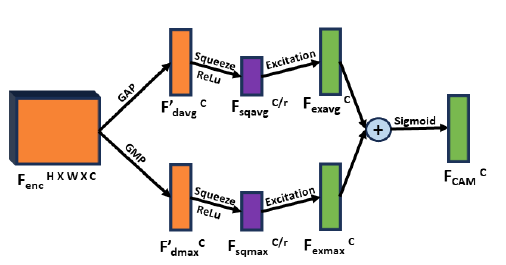

# FCS ( Fuzzy Channel Selection )

* Purpose:
    - Select most informative channels

* Structure:
    - Learnable mask mapped with Richard Sigmoid
    - [Richard Sigmoid](https://www.sciencedirect.com/science/article/abs/pii/S0305736499908776) [5] is used to ensure selection of relevant channels. Stepper curve ensure higher
    - Values for important channel. Larger curve is like have something uniform

* Learnable parameters:
    - $A$: scaling factor
    - $Q $:  stepness of the curve
    - $\mu $: stepness of the curve
    

$$
$$

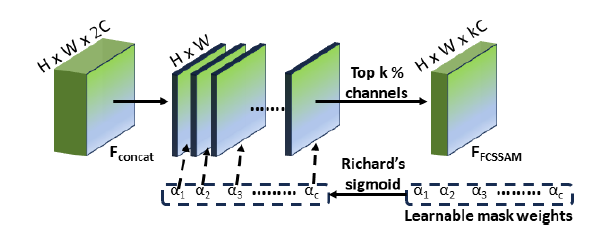



# Dataset and Network classes
* Input: RGB image 256x256x3 from [Kermany Dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) [4]
* Features extraction: convolutional layer of pre-trained model DenseNet-121
* Features select: FCSSAM module, it use Channel Attention Module and [Richard Sigmoid [5]](https://www.sciencedirect.com/science/article/abs/pii/S0305736499908776)
* classifier: [KAN: Kolmogorov-Arnold Networks](https://arxiv.org/pdf/2404.19756) [2]

Below you can find detailed information about each block

## ChestRayDataset

[Kermany Dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) [4] which contain 5856 chest X-Rays images divided in “Normal” and “Pneumonia” classes:
* Training images: 5216
* Test images: 624
* Validation images: 16



In [ ]:
class ChestRayDataset(Dataset):

    def __init__(self,file_path, transform):
        self.file_path = file_path
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.file_path))

    def __getitem__(self, index):
        sample_path = self.file_path + "/" + os.listdir(self.file_path)[index]
        sample = cv2.imread(sample_path)
        sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

        # Output of the class
        sample_tensor = self.transform(sample)
        label = sample_path.split("/")[-1].split("_")[1]

        if label == "normal":
            label = 0
        else:
            label = 1

        return sample_tensor,label

## Architecture

### Separable convolution

Pytorch implementation of a separable convolutional filter to reduce the number of required operation of a convolution

In [ ]:
class SeparableConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=7, padding='same', bias=True):
        super(SeparableConv2D, self).__init__()

        self.depthwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding,
            groups=in_channels,
            bias=bias
            )

        self.pointwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            bias=bias
            )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

### CAM ( Channel attention Module )
* Purpose:
    - Assign weight to each channels

* Structure:
    - Max and mean of each channels
    - Branches has an U-shape
    - Squeeze is performed with a separable convolutional layer

In [ ]:
class CAM(nn.Module):
    def __init__(self, channels, ratio=8, bias=False):
        super(CAM,self).__init__()

        self.fc1 = nn.Linear(
            in_features=channels,
            out_features=channels//ratio,
            bias=bias
            )

        self.fc2 = nn.Linear(
            in_features=channels//ratio,
            out_features=channels,
            bias=bias
            )

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.global_max_pool = nn.AdaptiveMaxPool2d((1,1))

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        # Input Tensor: torch.Size([1, 1024, 8, 8])
        x1 = torch.mean(x, dim=(2,3)) # GAP: torch.Size([1, 1024])
        x1 = self.fc1(x1) # GAP + Dense: torch.Size([1, 128])
        x1 = self.relu(x1)
        x1 = self.fc2(x1) # GAP + Dense + Dense: torch.Size([1, 1024])


        x2 = self.global_max_pool(x) # GMP: torch.Size([1, 1024, 1, 1])
        x2 = x2.view(x2.size(0), -1) # view: torch.size([1, 1024])
        x2 = self.fc1(x2) # GMP + Dense: torch.Size([1, 128])
        x2 = self.relu(x2)
        x2 = self.fc2(x2) # GMP + Dense + Dense: torch.Size([1, 1024])

        feats = x1 + x2 # Feats shape: torch.Size([1, 1024])
        feats = self.sigmoid(feats)
        feats = feats.view(feats.size(0), feats.size(1), 1, 1) # feats.shape: torch.Size([1, 1024, 1, 1])
        feats = torch.mul(x, feats) # Output shape: torch.Size([1, 1024, 8, 8])
        return feats

### SAM ( Spatial Attention Module )
Attention module used for suppress less relevant information and amplify the most relevant ones


In [ ]:
class SAM_avg (nn.Module):
    def __init__(self, channels, padding='same'):

        super(SAM_avg, self).__init__()

        self.sep_conv2d_1 = SeparableConv2D(
            in_channels=channels,
            out_channels=channels,
            kernel_size=1,
            padding=padding
        )

        self.sep_conv2d_2 = SeparableConv2D(
            in_channels=channels,
            out_channels=channels,
            kernel_size=3,
            padding=padding
        )

        self.batchnorm2d = nn.BatchNorm2d(channels)

        self.conv2d_3 = nn.Conv2d(
            in_channels=1,
            out_channels=1,
            kernel_size=7,
            padding=padding
        )

        self.sigm= nn.Sigmoid()

    def forward(self, x, cam):


        # Input tensor: torch.Size([1, 1024, 8, 8])

        x = self.sep_conv2d_1(x) # SepConv2d_1 shape: torch.Size([1, 1024, 8, 8])
        x = self.sep_conv2d_2(x) # SepConv2d_2 shape: torch.Size([1, 1024, 8, 8])
        x = self.batchnorm2d(x) # BatchNorm2d shape: torch.Size([1, 1024, 8, 8])
        x = x*cam # X*CAM shape: torch.Size([1, 1024, 8, 8])

        x1 = torch.mean(x, dim=1, keepdim=True) # Mean pooling shape: torch.Size([1, 1, 8, 8])

        feats = self.conv2d_3(x1) # Conv2d shape: torch.Size([1, 1, 8, 8])
        feats = self.sigm(feats)
        out = x * feats # Output shape: torch.Size([1, 1024, 8, 8])

        return out

In [ ]:
class SAM_max (nn.Module):
    def __init__(self, channels, padding='same'):

        super(SAM_max, self).__init__()  # Initialize nn.Module

        self.sep_conv2d_1 = SeparableConv2D(
            in_channels=channels,
            out_channels=channels,
            kernel_size=1,
            padding=padding
        )

        self.sep_conv2d_2 = SeparableConv2D(
            in_channels=channels,
            out_channels=channels,
            kernel_size=3,
            padding=padding
        )

        self.batchnorm2d = nn.BatchNorm2d(channels)

        self.conv2d_3 = nn.Conv2d(
            in_channels=1,
            out_channels=1,
            kernel_size=7,
            padding=padding
        )

        self.sigm= nn.Sigmoid()

    def forward(self, x, cam):

        # input: torch.Size([1, 1024, 8, 8])

        x = self.sep_conv2d_1(x) # SepConv2d_1 shape: torch.Size([1, 1024, 8, 8])
        x = self.sep_conv2d_2(x) # SepConv2d_2 shape: torch.Size([1, 1024, 8, 8])
        x = self.batchnorm2d(x) # BatchNorm2d shape: torch.Size([1, 1024, 8, 8])
        x = x*cam # X*CAM shape: torch.Size([1, 1024, 8, 8])

        # Max Pooling
        x2, _ = torch.max(x, dim=1, keepdim=True) # MAX pooling shape: torch.Size([1, 1, 8, 8])

        # Convolution and Multiplication
        feats = self.conv2d_3(x2) # Conv2d shape: torch.Size([1, 1, 8, 8])
        feats = self.sigm(feats)
        out = x*feats # Output shape: torch.Size([1, 1024, 8, 8])

        return out

### FCS ( Fuzzy Channel Selection )

* Purpose:
    - Select most informative channels

* Structure:
    - Learnable mask mapped with Richard Sigmoid
    - [Richard Sigmoid](https://www.sciencedirect.com/science/article/abs/pii/S0305736499908776) [5] is used to ensure selection of relevant channels. Stepper curve ensure higher
    - Values for important channel. Larger curve is like have something uniform

* Learnable parameters:
    - $A$: scaling factor
    - $Q $:  stepness of the curve
    - $\mu $: stepness of the curve
    

$$
$$



In [ ]:
class RichardsSigmoid(nn.Module):
    def __init__(self, units=1, bias=True):
        super(RichardsSigmoid, self).__init__()

        self.A = nn.Parameter(torch.Tensor(units))
        self.Q = nn.Parameter(torch.Tensor(units))
        self.mu = nn.Parameter(torch.Tensor(units))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.zeros_(self.A)
        nn.init.zeros_(self.Q)
        nn.init.zeros_(self.mu)

    def forward(self, x):
        # Richards sigmoid function
        return 1 / (1 + torch.exp(-self.A * torch.exp(-self.Q * (x - self.mu))))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.units,)

In [ ]:
class ChannelDropout(nn.Module):
    def __init__(self, channels, drop_ratio=0.2):
        super(ChannelDropout, self).__init__()

        self.drop_ratio = drop_ratio # Ratio of channels to be dropped.

        # Build the Mask with ones
        self.mask = nn.Parameter(torch.ones(1, channels, 1 , 1))

        # Build the Richard Sigmoid to apply to the mask
        self.r_sigm = RichardsSigmoid(units=1)

    def forward(self, x):
        # Apply the Richard Sigmoid to the mask
        mask = self.r_sigm(self.mask) # MASK Shape: torch.Size([1, 3072, 1, 1])

        # Repeat the mask as the batch size of the input (to apply to all the features)
        batch_size = x.size(0)
        mask_replicated = mask.repeat(batch_size, 1, 1, 1)

        # Apply the mask to the input
        x = x * mask_replicated # Input after Mask: torch.Size([1, 3072, 8, 8])

        # New Channel dimension
        new_n_channels = int(x.shape[1] * (1 - self.drop_ratio))

        # Perform top-k operation along the channels dimension (dim=1)
        # Keep the channels with highest values
        _, indices = torch.topk(x, k=new_n_channels, dim=1, largest=True)
        output = torch.gather(x, dim=1, index=indices)

        return output

### CSSAM
Module which implements the above pipeline

In [ ]:
class CSSAM (nn.Module):
    def __init__(self, channels, padding='same', ratio=8, bias=False, drop_ratio=0.2):

        super(CSSAM, self).__init__()  # Initialize nn.Module


        self.SamAvg = SAM_avg(
            channels=channels,
            padding=padding
            )

        self.SamMax = SAM_max(
            channels=channels,
            padding=padding
            )

        self.cam = CAM(
            channels=channels,
            ratio=ratio,
            bias=bias
            )

        self.ch_dropout = ChannelDropout(
            channels=channels*3,
            drop_ratio=drop_ratio
            )

    def forward(self, x):

        cam = self.cam(x)

        # SAM average and SAM max
        x_avg = self.SamAvg(x, cam) # SAM_avg shape: torch.Size([1, 1024, 8, 8])
        x_max = self.SamMax(x, cam) # SAM_max shape: torch.Size([1, 1024, 8, 8])

        # Concatenation
        x = torch.cat((x_avg, x_max, cam), dim=1) # Concatenation shape: torch.Size([1, 3072, 8, 8])

        # Channel Dropout
        out = self.ch_dropout(x) # Channel Dropout shape: torch.Size([1, 1536, 8, 8])

        return out

### JAM-net
Pytorch implementate of the network using wrapper JAM to ensure modularity.








In [ ]:
class JAM_network(nn.Module):
    def __init__(self, channels, padding='same', drop_ratio=0.2, dropout_rate=0.35 ):
        super(JAM_network,self).__init__()

        self.densenet121 = models.densenet121(pretrained=True).features

        self.cssam = CSSAM(
            channels=channels,
            padding=padding,
            drop_ratio=drop_ratio
            )

        self.dropout = nn.Dropout(
            p=dropout_rate
            )


        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)


    def forward(self, x):

        # Input Shape: torch.Size([1, 3, 256, 256])

        # BACKBONE
        x_dense = self.densenet121(x) # x_dense.shape: torch.Size([1, 1024, 8, 8])

        # CSSAM
        x_cssam = self.cssam(x_dense) # CSSAM shape: torch.Size([1, 2457, 8, 8])

        # GAP
        feats = self.global_avg_pool(x_cssam) # GAP shape: torch.Size([1, 2457, 1, 1])
        feats = torch.flatten(feats, start_dim=1) # Flattening shape: torch.Size([1, 2457])

        # DROPOUT
        feats = self.dropout(feats) # dropout: torch.Size([1, 2457])

        return feats

In [ ]:
class JAM(nn.Module):
    def __init__(self, channels, device, model_name, padding='same', drop_ratio=0.2, dropout_rate=0.35):
        super().__init__()

        self.body = JAM_network(
            channels=channels,
            padding=padding,
            drop_ratio=drop_ratio,
            dropout_rate=dropout_rate
            ).to(device)

        self.kan_ch = int(channels * 3 * (1 - drop_ratio))
        self.classifier = KAN([ self.kan_ch, 1])
        self.classifier.to(device)

        self.sig = nn.Sigmoid()

        self.loss_fn = nn.BCELoss()
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=0.0001) # torch.optim.SGD(self.model.parameters(), lr=0.1)

        self.accuracy = BinaryAccuracy()
        self.precision = BinaryPrecision()
        self.recall = BinaryRecall()
        self.auroc = BinaryAUROC()
        self.f1score = BinaryF1Score()

        self.model_name = model_name

    def set_training_mode(self):
        self.body.train()

    def set_eval_mode(self):
        self.body.eval()

    def forward(self, model_input):
        out_body = self.body(model_input)
        out_cls = self.classifier(out_body)
        out = self.sig(out_cls)
        return out

    def save(self, epoch):
        name = self.model_name + f"{epoch}.pt"
        torch.save(self.state_dict(), name )

    def load(self):
        name = self.model_name
        try:
            self.load_state_dict(torch.load(name) )
            print(f"{Color.MAGENTA}loaded: {name}{Color.RESET}")
        except Exception as e:
            print(f"{Color.RED}Model not loaded{Color.RESET}")
            print(e)

print(device)
jam_try = JAM(1024, device=device, model_name="jam_model.pt")
t = torch.rand([2, 3, 256, 256]).to(device)
print(f"input tensor: {t.shape}")

out = jam_try(t)
print(f"out.shape: {out.shape},\n{out}")

cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 134MB/s]


Directory created: ./model
input tensor: torch.Size([2, 3, 256, 256])
out.shape: torch.Size([2, 1]),
tensor([[0.7643],
        [0.6458]], device='cuda:0', grad_fn=<SigmoidBackward0>)


# Dataset informations
In this module we performed exploration of the [Kermany Dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)  [4]:
* Training images: 5216
* Test images: 624
* Validation images: 16

It is possibile to see data distribution and preprocessed images below

<br>

Augmentation: applied with probability P=0.15 each transformation
* [Random Rotations](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomRotation.html) (degrees = 0-20)
* [Random Crop and Resize](https://pytorch.org/vision/main/generated/torchvision.transforms.functional.resized_crop.html) (scale = 0.8-1.0)
* [Random Horizontal Flip](https://pytorch.org/vision/0.18/generated/torchvision.transforms.RandomHorizontalFlip.html) (p = 1)

<br>

Agumentation tecniques are taken from the paper [A Deep Feature Learning Model for Pneumonia Detection Applying a Combination of mRMR Feature Selection and Machine Learning Models](https://www.sciencedirect.com/science/article/abs/pii/S1959031819301174)

## Download and merge of the dataset

In [ ]:
download_dataset(
     link_dataset=global_var['link_dataset'],
     delete_zip_file=False
 )

merge_dataset()

Downloading...
From (original): https://drive.google.com/uc?export=download&id=10un_W7teXQy9LOB1uqd0e6VJ46UFNRza
From (redirected): https://drive.google.com/uc?export=download&id=10un_W7teXQy9LOB1uqd0e6VJ46UFNRza&confirm=t&uuid=370c61be-e0ea-410b-9170-e11fe04f8545
To: /content/dataset.zip
100%|██████████| 2.46G/2.46G [01:00<00:00, 40.9MB/s]



Zip file downloaded


Unzipping files:   0%|          | 0/17591 [00:00<?, ?it/s]

Dataset chest_xray unzipped
Dataset reordered and labelled


In [ ]:
size = global_var["resizing_dim"] # Choose the size

resize_and_save(
    mode='bilinear',    # Choose the mode of interpolation ('nearest', 'bilinear', 'bicubic', ...)
    size=size
)

Resizing train images:   0%|          | 0/5216 [00:00<?, ?image/s]

Resizing test images:   0%|          | 0/624 [00:00<?, ?image/s]

Resizing val images:   0%|          | 0/16 [00:00<?, ?image/s]

In [ ]:
probs = 0.15

resize_crop_transform = transforms.RandomResizedCrop(size=size, scale=(0.8, 1.0))  # For zoom and size change
rotation_transform = transforms.RandomRotation(degrees=(0,20))  # For random rotation
horizontal_flip_transform = transforms.RandomHorizontalFlip(p=1.0)  # For horizontal flip


tr_augmentation = transforms.Compose([
     transforms.RandomApply( [resize_crop_transform], p=probs ),
     transforms.RandomApply( [rotation_transform], p=probs ),
     transforms.RandomApply( [horizontal_flip_transform], p=probs ),

])

data_augmentation(tr_augmentation)

Augmenting data:   0%|          | 0/2534 [00:00<?, ?it/s]

In [ ]:
dataset_directory = global_var["extract_directory"] + "/" + global_var["dataset_name_resized_augmented"]
gaussian_he_directory = global_var["extract_directory"] + "/" + global_var["dataset_name_gaussian_he"]

create_preprocessed_dataset(
    dataset_path = dataset_directory,
    new_dataset_path = gaussian_he_directory,
    mode = 'gaussian_he'
)

Processing val:   0%|          | 0/16 [00:00<?, ?it/s]

Processing test:   0%|          | 0/624 [00:00<?, ?it/s]

Processing train:   0%|          | 0/7750 [00:00<?, ?it/s]

In [ ]:
dataset_directory = global_var["extract_directory"] + "/" + global_var["dataset_name_resized_augmented"]
gaussian_directory = global_var["extract_directory"] + "/" + global_var["dataset_name_gaussian"]

create_preprocessed_dataset(
    dataset_path = dataset_directory,
    new_dataset_path = gaussian_directory,
    mode = 'gaussian'
)

Processing val:   0%|          | 0/16 [00:00<?, ?it/s]

Processing test:   0%|          | 0/624 [00:00<?, ?it/s]

Processing train:   0%|          | 0/7750 [00:00<?, ?it/s]

In [ ]:
dataset_directory = global_var["extract_directory"] + "/" + global_var["dataset_name_resized_augmented"]
heatmap_directory = global_var["extract_directory"] + "/" + global_var["dataset_name_heatmap"]

create_preprocessed_dataset(
    dataset_path = dataset_directory,
    new_dataset_path = heatmap_directory,
    mode = 'heatmap'
)

Processing val:   0%|          | 0/16 [00:00<?, ?it/s]

Processing test:   0%|          | 0/624 [00:00<?, ?it/s]

Processing train:   0%|          | 0/7750 [00:00<?, ?it/s]

## Dataset exploration, augmentation and visualization

In this part we plot an:

1. *Histogram Distribution* : to see if the dataset is balanced or unbalanced

2. *Pie Chart* : to visualize the sizes of training, test and validation sets

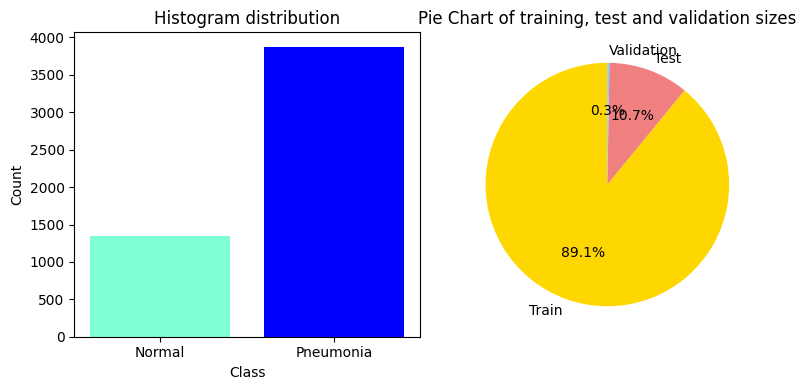


The number of training images: 5216
The number of test images: 624
The number of validation images: 16

The number of normal images:  1583
The number of pneumonia images:  4273


In [ ]:
# @title Initial statistic of dataset
# Definition of the paths for training, test and validation set
path_training_set = "/content/chest_xray/train"
path_test_set = "/content/chest_xray/test"
path_val_set = "/content/chest_xray/val"

# Counting the Normal and Pneumonia images in the training set
train_norm, train_pneu = counter(path_training_set, labels = True); # Count the number of normal images and pneumonia images

train_num = counter(path_training_set, labels = False);
test_num = counter(path_test_set, labels = False);
val_num = counter(path_val_set, labels = False);

# Histogram Data
classes_hist = ['Normal', 'Pneumonia']
counts_hist = [train_norm, train_pneu]
colors_hist = ['aquamarine', 'blue']

# Pie Chart Data
classes_pie = ['Train', 'Test', 'Validation']
counts_pie = [train_num, test_num, val_num]
colors_pie = ['gold', 'lightcoral', 'lightskyblue']

# Create a figure with specific dimensions and subplots
fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # Adjust figsize as needed

# Plotting the histogram
ax[0].bar(classes_hist, counts_hist, color=colors_hist)
ax[0].set_title('Histogram distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

# Plotting the pie chart
ax[1].pie(counts_pie, labels=classes_pie, colors=colors_pie, autopct='%1.1f%%', startangle=90)
ax[1].set_title('Pie Chart of training, test and validation sizes')

plt.tight_layout()  # This adjusts subplot params so that the subplots fit into the figure area.
plt.show()

print("\nThe number of training images:", train_num)
print("The number of test images:", test_num)
print("The number of validation images:", val_num)

train_num_norm, train_num_pn = counter(path_training_set, labels = True);
test_num_norm, test_num_pn= counter(path_test_set, labels = True);
val_num_norm, val_num_pn = counter(path_val_set, labels = True);

print("\nThe number of normal images: ", train_num_norm + test_num_norm + val_num_norm)
print("The number of pneumonia images: ", train_num_pn + test_num_pn + val_num_pn)

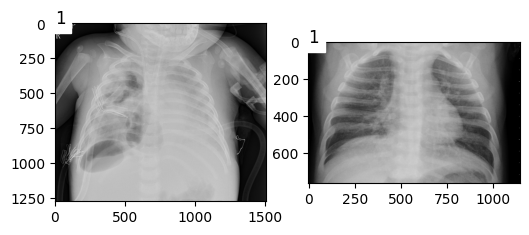

The shape of the first image is:  torch.Size([1272, 1512, 3])
The shape of the second image is:  torch.Size([760, 1144, 3])


In [ ]:
# @title Visualization of two random images
# Define a transform element to resize the images as square images and transform in Tensor
tr_1 = transforms.ToTensor()                # Convert the image to a tensor

# Definition of the paths for training, test and validation set
path_training_set = "/content/chest_xray/train"
path_test_set = "/content/chest_xray/test"
path_val_set = "/content/chest_xray/val"

# Instance of classes for the Dataset
train_dataset = ChestRayDataset(path_training_set, tr_1) # Create an instance of training class
test_dataset = ChestRayDataset(path_test_set, tr_1) # Create an instance of test class
val_dataset = ChestRayDataset(path_val_set, tr_1) # Create an instance of validation class

# Generate two random numbers to select two random images from training set
random_num_1 = np.random.randint(1, len(train_dataset))
random_num_2 = np.random.randint(1, len(train_dataset))

# Take an image + label randomly
img_1, label_1 = train_dataset[random_num_1]
img_2, label_2 = train_dataset[random_num_2]

# Display the image using matplotlib library
plt.figure( figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img_1.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_1, fontsize=12, color='black', backgroundcolor='white')

plt.subplot(1,2,2)
plt.imshow(img_2.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_2, fontsize=12, color='black', backgroundcolor='white')

plt.show()

print ("The shape of the first image is: ", img_1.permute(1, 2, 0).shape)
print ("The shape of the second image is: ", img_2.permute(1, 2, 0).shape)

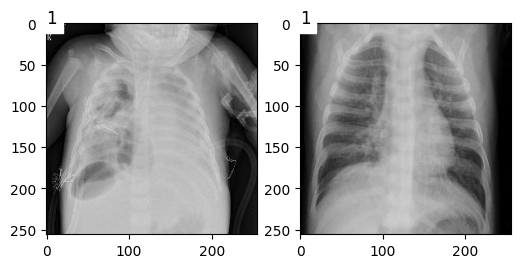

The shape of the first image is:  torch.Size([256, 256, 3])
The shape of the second image is:  torch.Size([256, 256, 3])


In [ ]:
# @title Squarring

# Define a transform element to resize the images as square images and transform in Tensor
tr_1 = transforms.ToTensor()                 # Convert the image to a tensor

# Definition of the paths for training, test and validation set
path_training_set_resized = "/content/chest_xray_resized/train"
path_test_set_resized = "/content/chest_xray_resized/test"
path_val_set_resized = "/content/chest_xra_resized/val"

# Instance of classes for the Dataset
train_dataset_resized = ChestRayDataset(path_training_set_resized, tr_1) # Create an instance of training class
test_dataset_resized = ChestRayDataset(path_test_set_resized, tr_1) # Create an instance of test class
val_dataset_resized = ChestRayDataset(path_val_set_resized, tr_1) # Create an instance of validation class

# Take an image + label randomly
img_1, label_1 = train_dataset_resized[random_num_1]
img_2, label_2 = train_dataset_resized[random_num_2]

# Display the image using matplotlib library
plt.figure( figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img_1.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_1, fontsize=12, color='black', backgroundcolor='white')

plt.subplot(1,2,2)
plt.imshow(img_2.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_2, fontsize=12, color='black', backgroundcolor='white')

plt.show()

print ("The shape of the first image is: ", img_1.permute(1, 2, 0).shape)
print ("The shape of the second image is: ", img_2.permute(1, 2, 0).shape)

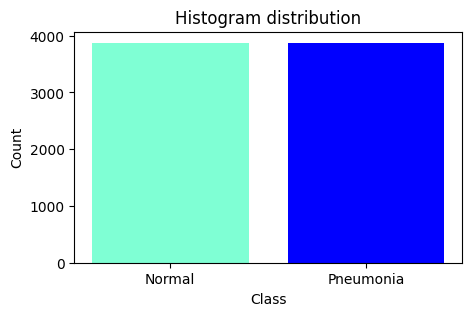

The number of normal images: 3875
The number of pneumonia images: 3875


In [ ]:
# @title Statistics after data augmentation
# Definition of the paths for training, test and validation set
path_training_set_resized_augmented = "/content/chest_xray_resized_augmented/train"

# Counting the Normal and Pneumonia images in the training set
train_norm, train_pneu = counter(path_training_set_resized_augmented, labels = True); # Count the number of normal images and pneumonia images

# Histogram Data
classes_hist = ['Normal', 'Pneumonia']
counts_hist = [train_norm, train_pneu]
colors_hist = ['aquamarine', 'blue']


plt.figure(figsize=(5, 3))
plt.bar(classes_hist, counts_hist, color=colors_hist)
plt.title('Histogram distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

print("The number of normal images:", train_norm)
print("The number of pneumonia images:", train_pneu)


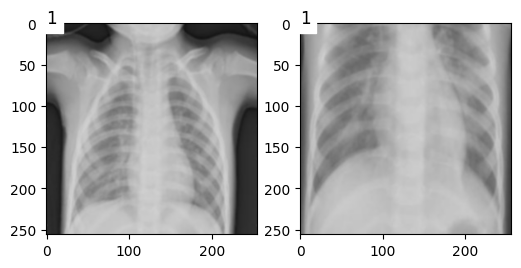

In [ ]:
# @title Visualization of two sample in gaussian dataset
# Instance of classes for the Dataset
path_training_set_gaussian = "/content/chest_xray_gaussian/train"
train_dataset_gaussian = ChestRayDataset(path_training_set_gaussian, tr_1) # Create an instance of training class

# Generate two random numbers to select two random images from training set
random_num_1 = np.random.randint(1, len(train_dataset_gaussian))
random_num_2 = np.random.randint(1, len(train_dataset_gaussian))

# Take an image + label randomly
img_1, label_1 = train_dataset_gaussian[random_num_1]
img_2, label_2 = train_dataset_gaussian[random_num_2]

# Display the image using matplotlib library
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img_1.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_1, fontsize=12, color='black', backgroundcolor='white')

plt.subplot(1,2,2)
plt.imshow(img_2.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_2, fontsize=12, color='black', backgroundcolor='white')

plt.show()

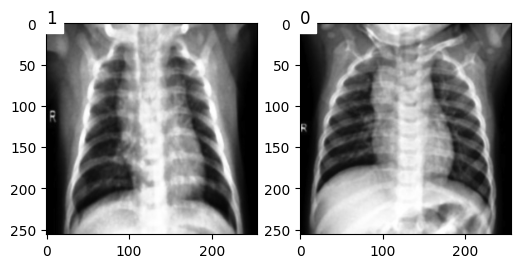

In [ ]:
# @title Visualization of two sample in gaussian_he dataset
# Instance of classes for the Dataset
path_training_set_gaussian_he = "/content/chest_xray_gaussian_he/train"
train_dataset_gaussian_he = ChestRayDataset(path_training_set_gaussian_he, tr_1) # Create an instance of training class

# Generate two random numbers to select two random images from training set
random_num_1 = np.random.randint(1, len(train_dataset_gaussian_he))
random_num_2 = np.random.randint(1, len(train_dataset_gaussian_he))

# Take an image + label randomly
img_1, label_1 = train_dataset_gaussian_he[random_num_1]
img_2, label_2 = train_dataset_gaussian_he[random_num_2]

# Display the image using matplotlib library
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img_1.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_1, fontsize=12, color='black', backgroundcolor='white')

plt.subplot(1,2,2)
plt.imshow(img_2.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_2, fontsize=12, color='black', backgroundcolor='white')

plt.show()

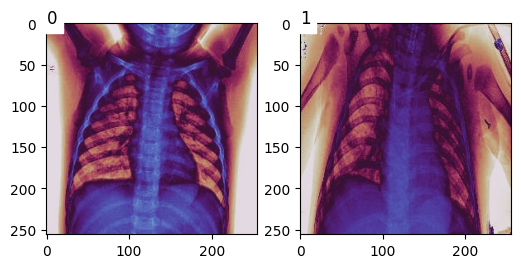

In [ ]:
# @title Visualization of two sample in heatmap dataset
# Instance of classes for the Dataset
path_training_set_heatmap = "/content/chest_xray_heatmap/train"
train_dataset_heatmap = ChestRayDataset(path_training_set_heatmap, tr_1) # Create an instance of training class

# Generate two random numbers to select two random images from training set
random_num_1 = np.random.randint(1, len(train_dataset_heatmap))
random_num_2 = np.random.randint(1, len(train_dataset_heatmap))

# Take an image + label randomly
img_1, label_1 = train_dataset_heatmap[random_num_1]
img_2, label_2 = train_dataset_heatmap[random_num_2]

# Display the image using matplotlib library
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img_1.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_1, fontsize=12, color='black', backgroundcolor='white')

plt.subplot(1,2,2)
plt.imshow(img_2.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_2, fontsize=12, color='black', backgroundcolor='white')

plt.show()

# Training
Training loop from [documentation](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html)
and modified according our need. In particular have been implemented a system of RAM clearing and saving of the metrics during all the phases in order to study data in the aftermath.

Metrics used are
*   [BinaryAccuracy](https://lightning.ai/docs/torchmetrics/stable/classification/accuracy.html): to evaluate how much correct predictions the network does $$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$
*   [BinaryRecall](https://lightning.ai/docs/torchmetrics/stable/classification/recall.html): in medical field it is important to avoid false negative so avoid to classify a radiography with diseased lungs as healty $$ \text{Recall} = \frac{TP}{TP + FN} $$
* [BinaryPrecision](https://lightning.ai/docs/torchmetrics/stable/classification/precision.html): used to detect positive predicted value $$ \text{Precision} = \frac{TP}{TP + FP} $$
*   [BinaryF1Score](https://lightning.ai/docs/torchmetrics/stable/classification/f1_score.html): used to computed average of precision and recall, used to evaluate overall performance $$ \text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} $$
* [BinaryAuroc](https://lightning.ai/docs/torchmetrics/stable/classification/auroc.html) area under curve of ratio between true and false positive

## Train functions

In [ ]:
def save_metrics_to_csv(metrics_dict, name_dict):

    with open(name_dict, 'w') as f:
        json.dump(metrics_dict,f)

    print(f"{Color.GREEN}{name_dict} saved{Color.RESET}")

In [ ]:
def load_metrics_from_csv(path):

    if os.path.exists(path):
        with open(path, 'r') as f:
            loaded_data = json.load(f)

        print(f"{Color.GREEN}{path} loaded{Color.RESET}")
        return loaded_data
    else:
        print(f"{Color.RED}{path} not loaded, return {{}}{Color.RESET}")
        return {}

In [ ]:
def my_plot(train_dict, x_axis1, y_axis1, val_dict, x_axis2, y_axis2, title,
            marker1='o', linestyle1='-', color1='b',
            marker2='x', linestyle2='-', color2='r'):

    x_values1 = train_dict[x_axis1]
    y_values1 = train_dict[y_axis1]

    x_values2 = val_dict[x_axis2]
    y_values2 = val_dict[y_axis2]

    plt.figure(figsize=(8, 5))

    # Plot the first function
    plt.plot(x_values1, y_values1, marker=marker1, linestyle=linestyle1, color=color1, label="Training " + y_axis1)

    # Plot the second function
    plt.plot(x_values2, y_values2, marker=marker2, linestyle=linestyle2, color=color2, label="Validation " + y_axis2)

    plt.xlabel(f"{x_axis1}")
    plt.ylabel(f"{y_axis1}")
    plt.title(f"{title}")
    plt.legend()

    # Ensure the x-axis has integer ticks
    x_min = min(min(x_values1), min(x_values2))
    x_max = max(max(x_values1), max(x_values2))
    plt.xticks(range(x_min, x_max + 1))

    plt.show()

In [ ]:
def plot_confusion_matrix(cm, class_names, normalize=False, title='Confusion Matrix', cmap='Oranges'):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap,
                xticklabels=class_names, yticklabels=class_names)

    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [ ]:
def calculate_metrics(model, outputs, labels, metrics_dict):

    accuracy_value = model.accuracy(outputs, labels)
    precision_value = model.precision(outputs, labels)
    recall_value = model.recall(outputs, labels)
    auroc_value = model.auroc(outputs, labels)
    f1score_value = model.f1score(outputs, labels)


    metrics_dict['accuracy'].append(accuracy_value.item())
    metrics_dict['precision'].append(precision_value.item())
    metrics_dict['recall'].append(recall_value.item())
    metrics_dict['auroc'].append(auroc_value.item())
    metrics_dict['f1score'].append(f1score_value.item())


    metrics_string = f"\n\taccuracy: {accuracy_value:.2f}, precision: {precision_value:.2f}, recall: {recall_value:.2f}, auroc: {auroc_value:.2f}, f1score: {f1score_value:.2f}"
    print(metrics_string)
    return accuracy_value

In [ ]:
def train_one_epoch(model, epoch_index, training_loader, metrics_train):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting

    n_batch = len(training_loader)  # number of batches in training loader

    with tqdm(total=n_batch, desc=f'Epoch {epoch_index+1} ') as pbar:
        for i, data in enumerate(training_loader):

            # Every data instance is an input + label pair
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            labels = labels.unsqueeze(dim=1)     # reshaping as inputs, from [0, 1] to [[0], [1]]
            labels = labels.type(torch.float32)  # preditions of network are floats

            # Zero your gradients for every batch!
            model.optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(inputs)

            # Compute the loss and its gradients
            loss = model.loss_fn(outputs, labels)
            loss.backward()

            # Adjust learning weights
            model.optimizer.step()

            # Gather data and report
            running_loss += loss.item()

            if i % batch_size == 0 and i>0:
                last_loss = running_loss / batch_size #1000 # loss per batch
                print(f'\r\tbatch {i+1} loss: {last_loss}', end='')
                running_loss = 0.

                del inputs, labels, outputs, loss
                gc.collect()

                if device != "cpu":
                    torch.cuda.empty_cache()

            # compute metrics in last epoch
            if i == n_batch-1:
                current_accuracy = calculate_metrics(model, outputs, labels, metrics_train)

            pbar.update(1)

        # Svuota la cache CUDA dopo ogni epoca
        torch.cuda.empty_cache()

        pbar.update(labels.shape[0])

    return last_loss

In [ ]:
def training(model, epochs, training_loader, validation_loader, metrics_train, metrics_validation):
    model.set_training_mode()

    best_vloss = 1000000
    epoch_number = 0
    current_accuracy = 0.0
    EARLY_STOPPING = 0

    for epoch in range(epochs):

        # Make sure gradient tracking is on, and do a pass over the data
        model.set_training_mode()
        avg_loss = train_one_epoch(model, epoch, training_loader, metrics_train)

        metrics_train['loss'].append(avg_loss)
        metrics_train['epoch'].append(epoch)

        running_vloss = 0.0

        model.set_eval_mode()
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata

                vinputs = vinputs.to(device)
                vlabels = vlabels.to(device)

                vlabels = vlabels.unsqueeze(dim=1)    # [0, 1, 0, 1] -> [[0], [1], [0], [1]]
                vlabels = vlabels.type(torch.float32)

                voutputs = model(vinputs)
                vloss = model.loss_fn(voutputs, vlabels)

                running_vloss += vloss

                metrics_validation['loss'].append(vloss.item())
                metrics_validation['epoch'].append(epoch)

                current_accuracy = calculate_metrics(model, voutputs, vlabels, metrics_validation)

        model.save(epoch_number)
        save_metrics_to_csv(metrics_train, '/content/train_metrics.json')
        save_metrics_to_csv(metrics_validation, '/content/validation_metrics.json')

        avg_vloss = running_vloss / ( i + 1 )
        print(f"\taverage loss train: {avg_loss:.4f}, average loss validation: {avg_vloss:.4f}\n")

        if avg_vloss < best_vloss:
            best_vloss = avg_loss
            model_path = model.model_name #f'/content/model_{epoch_number}'
            torch.save(model.state_dict(), model_path)
            print(f"{Color.MAGENTA}Saved: {model.model_name}{Color.RESET}")

        if epoch >= 1:
            loss_1 = metrics_train['loss'][-2]
            loss_2 = metrics_train['loss'][-1]

            if abs(loss_1 - loss_2) <= 1e-4:
                EARLY_STOPPING += 1
                print(f"{Color.RED}Early stop counter incremented: {EARLY_STOPPING}{Color.RESET}")
            else:
                EARLY_STOPPING = 0

        if EARLY_STOPPING >= 2:
            print(f"{Color.RED}Early Stopping{Color.RESET}")
            break

In [ ]:
def testing(model, test_loader, metrics_test):

    model.set_eval_mode()
    running_tloss = 0

    n_batch = len(test_loader)  # number of batches in training loader
    batch_size = global_var['batch_size']
    n_files = n_batch*batch_size

    with tqdm(total=n_files, desc=f'Testing ') as pbar:

        with torch.no_grad():
            for i, tdata in enumerate(test_loader):

                tinputs, tlabels = tdata

                tinputs = tinputs.to(device)
                tlabels = tlabels.to(device)

                tlabels = tlabels.unsqueeze(dim=1)    # [0, 1, 0, 1] -> [[0], [1], [0], [1]]
                tlabels = tlabels.type(torch.float32)

                if i == 0:
                    outputs_tensor = torch.empty(0, tlabels.shape[1], device=device)
                    labels_tensor = torch.empty(0, tlabels.shape[1], device=device)

                toutputs = model(tinputs)
                tloss = model.loss_fn(toutputs, tlabels)

                metrics_test['loss'].append(tloss.item())
                metrics_test['iteration'].append(i)

                running_tloss += tloss

                outputs_tensor = torch.cat((outputs_tensor, toutputs), dim=0)
                labels_tensor = torch.cat((labels_tensor, tlabels), dim=0)

                pbar.update(tlabels.shape[0])

            _ = calculate_metrics(model, outputs_tensor, labels_tensor, metrics_test)

            labels_tensor = labels_tensor.cpu()
            labels_tensor = labels_tensor.squeeze(dim=1) # [[0], [1], [0], [1]] -> [0, 1, 0, 1]
            true_labels_np = labels_tensor.numpy().astype(int)

            outputs_tensor = outputs_tensor.cpu()
            outputs_tensor = outputs_tensor.squeeze(dim=1) # [[0], [1], [0], [1]] -> [0, 1, 0, 1]
            predicted_labels_np = outputs_tensor.numpy()
            threshold = 0.5
            predicted_labels_np = (predicted_labels_np > threshold).astype(int)

    return true_labels_np, predicted_labels_np

In [ ]:
print(device)
batch_size = global_var["batch_size"]
train_epochs = global_var["train_epochs"]
tf_to_tensor = transforms.ToTensor()

cuda:0


# Main
Execution of the program


1.  Creation of dataset [Kermany Dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) and respective dataloader
2.  Preparation of datastructure to save metrics during training, evalutation and testing
3.  Training of the network
4.  Save of the weight and all metrics in order to have an history of the training. Metrics
5.  Plots of metrics


In [ ]:
#base_path = global_var['extract_directory'] + "/" + global_var['dataset_name_resized_augmented']

dt_train_path = global_var['extract_directory'] + "/" + global_var['dataset_name_resized_augmented'] + '/train'
dt_test_path = global_var['extract_directory'] + "/" + global_var['dataset_name_resized_augmented'] + '/test'
dt_val_path = global_var['extract_directory'] + "/" + global_var['dataset_name_resized_augmented'] + '/val'

print(dt_train_path)
print(dt_test_path)
print(dt_val_path)

/content/chest_xray_resized_augmented/train
/content/chest_xray_resized_augmented/test
/content/chest_xray_resized_augmented/val


In [ ]:
dt_train_dataset = ChestRayDataset(
    file_path= dt_train_path,
    transform=tf_to_tensor
)

dt_test_dataset = ChestRayDataset(
    file_path= dt_test_path,
    transform=tf_to_tensor
)

dt_val_dataset = ChestRayDataset(
    file_path= dt_val_path,
    transform=tf_to_tensor
)


In [ ]:
dt_train_dataloader = DataLoader(
    dt_train_dataset,
    batch_size=batch_size,
    shuffle=True
    )

dt_test_dataloader = DataLoader(
    dt_test_dataset,
    batch_size=batch_size,
    shuffle=True
    )

dt_val_dataloader = DataLoader(
    dt_val_dataset,
    batch_size=batch_size,
    shuffle=True
    )

In [ ]:
gc.collect()
if device != "cpu":
    torch.cuda.empty_cache()

jam_network = JAM(
    channels=1024,
    device=device,
    model_name=global_var['extract_directory'] + "/" + "jam_net"
    )

#jam_network.load() # Decomment this to load precedent weights
jam_network.to(device)
jam_network.set_eval_mode()

gc.collect()
if device != "cpu":
    torch.cuda.empty_cache()


train_metrics = {}
train_metrics['epoch'] = []
train_metrics['loss'] = []
train_metrics['accuracy'] = []
train_metrics['precision'] = []
train_metrics['recall'] = []
train_metrics['auroc'] = []
train_metrics['f1score'] = []


validation_metrics = {}
validation_metrics['epoch'] = []
validation_metrics['loss'] = []
validation_metrics['accuracy'] = []
validation_metrics['precision'] = []
validation_metrics['recall'] = []
validation_metrics['auroc'] = []
validation_metrics['f1score'] = []


print("You are using for training: ", device)

training(jam_network, train_epochs, dt_train_dataloader, dt_val_dataloader, train_metrics, validation_metrics)

save_metrics_to_csv(train_metrics, '/content/train_metrics.json')
save_metrics_to_csv(validation_metrics, '/content/validation_metrics.json')

Directory already exists: ./model
You are using for training:  cuda:0


Epoch 1 :   0%|          | 0/162 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


	batch 145 loss: 0.06802387892579038
	accuracy: 0.95, precision: 0.92, recall: 1.00, auroc: 1.00, f1score: 0.96

	accuracy: 0.81, precision: 0.73, recall: 1.00, auroc: 1.00, f1score: 0.84
/content/train_metrics.json saved
/content/validation_metrics.json saved
	average loss train: 0.0680, average loss validation: 0.4115

Saved: /content/jam_net


Epoch 2 :   0%|          | 0/162 [00:00<?, ?it/s]

	batch 145 loss: 0.02808312781659576
	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00

	accuracy: 0.94, precision: 0.89, recall: 1.00, auroc: 1.00, f1score: 0.94
/content/train_metrics.json saved
/content/validation_metrics.json saved
	average loss train: 0.0281, average loss validation: 0.0983



Epoch 3 :   0%|          | 0/162 [00:00<?, ?it/s]

	batch 145 loss: 0.007302193146945986
	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00

	accuracy: 0.81, precision: 0.73, recall: 1.00, auroc: 1.00, f1score: 0.84
/content/train_metrics.json saved
/content/validation_metrics.json saved
	average loss train: 0.0073, average loss validation: 0.2832



Epoch 4 :   0%|          | 0/162 [00:00<?, ?it/s]

	batch 145 loss: 0.009935821797019647
	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00

	accuracy: 0.62, precision: 0.57, recall: 1.00, auroc: 1.00, f1score: 0.73
/content/train_metrics.json saved
/content/validation_metrics.json saved
	average loss train: 0.0099, average loss validation: 0.9823



Epoch 5 :   0%|          | 0/162 [00:00<?, ?it/s]

	batch 145 loss: 0.02352099485627453
	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00

	accuracy: 0.94, precision: 0.89, recall: 1.00, auroc: 1.00, f1score: 0.94
/content/train_metrics.json saved
/content/validation_metrics.json saved
	average loss train: 0.0235, average loss validation: 0.1854



Epoch 6 :   0%|          | 0/162 [00:00<?, ?it/s]

	batch 145 loss: 0.013825330315739848
	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00

	accuracy: 0.94, precision: 0.89, recall: 1.00, auroc: 1.00, f1score: 0.94
/content/train_metrics.json saved
/content/validation_metrics.json saved
	average loss train: 0.0138, average loss validation: 0.0941



Epoch 7 :   0%|          | 0/162 [00:00<?, ?it/s]

	batch 145 loss: 0.0029044906708198446
	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00

	accuracy: 0.94, precision: 0.89, recall: 1.00, auroc: 1.00, f1score: 0.94
/content/train_metrics.json saved
/content/validation_metrics.json saved
	average loss train: 0.0029, average loss validation: 0.2843



Epoch 8 :   0%|          | 0/162 [00:00<?, ?it/s]

	batch 145 loss: 0.008045691304081023
	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00

	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00
/content/train_metrics.json saved
/content/validation_metrics.json saved
	average loss train: 0.0080, average loss validation: 0.0053

Saved: /content/jam_net


Epoch 9 :   0%|          | 0/162 [00:00<?, ?it/s]

	batch 145 loss: 0.0030797661362763997
	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00

	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00
/content/train_metrics.json saved
/content/validation_metrics.json saved
	average loss train: 0.0031, average loss validation: 0.0129



Epoch 10 :   0%|          | 0/162 [00:00<?, ?it/s]

	batch 145 loss: 0.009332551688809568
	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00

	accuracy: 0.88, precision: 0.80, recall: 1.00, auroc: 1.00, f1score: 0.89
/content/train_metrics.json saved
/content/validation_metrics.json saved
	average loss train: 0.0093, average loss validation: 0.2104



Epoch 11 :   0%|          | 0/162 [00:00<?, ?it/s]

	batch 145 loss: 0.0020629680861929955
	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00

	accuracy: 0.81, precision: 0.73, recall: 1.00, auroc: 1.00, f1score: 0.84
/content/train_metrics.json saved
/content/validation_metrics.json saved
	average loss train: 0.0021, average loss validation: 1.0926



Epoch 12 :   0%|          | 0/162 [00:00<?, ?it/s]

	batch 145 loss: 0.001429966788236925
	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00

	accuracy: 0.94, precision: 0.89, recall: 1.00, auroc: 1.00, f1score: 0.94
/content/train_metrics.json saved
/content/validation_metrics.json saved
	average loss train: 0.0014, average loss validation: 0.3342



Epoch 13 :   0%|          | 0/162 [00:00<?, ?it/s]

	batch 145 loss: 0.00035573762321898056
	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00

	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00
/content/train_metrics.json saved
/content/validation_metrics.json saved
	average loss train: 0.0004, average loss validation: 0.0029

Saved: /content/jam_net


Epoch 14 :   0%|          | 0/162 [00:00<?, ?it/s]

	batch 145 loss: 0.00039944505366899347
	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00

	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00
/content/train_metrics.json saved
/content/validation_metrics.json saved
	average loss train: 0.0004, average loss validation: 0.0029

Early stop counter incremented: 1


Epoch 15 :   0%|          | 0/162 [00:00<?, ?it/s]

	batch 145 loss: 0.00017887251639573756
	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00

	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00
/content/train_metrics.json saved
/content/validation_metrics.json saved
	average loss train: 0.0002, average loss validation: 0.0440



Epoch 16 :   0%|          | 0/162 [00:00<?, ?it/s]

	batch 145 loss: 0.0002555896197312298
	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00

	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00
/content/train_metrics.json saved
/content/validation_metrics.json saved
	average loss train: 0.0003, average loss validation: 0.0084

Early stop counter incremented: 1


Epoch 17 :   0%|          | 0/162 [00:00<?, ?it/s]

	batch 145 loss: 0.0002387049675386758
	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00

	accuracy: 1.00, precision: 1.00, recall: 1.00, auroc: 1.00, f1score: 1.00
/content/train_metrics.json saved
/content/validation_metrics.json saved
	average loss train: 0.0002, average loss validation: 0.0094

Early stop counter incremented: 2
Early Stopping
/content/train_metrics.json saved
/content/validation_metrics.json saved


In [ ]:
test_metrics = {}
test_metrics['iteration'] = []
test_metrics['loss'] = []
test_metrics['accuracy'] = []
test_metrics['precision'] = []
test_metrics['recall'] = []
test_metrics['auroc'] = []
test_metrics['f1score'] = []

jam_network.load()
true_labels, predicted_labels = testing(jam_network, dt_test_dataloader, test_metrics)
save_metrics_to_csv(test_metrics, '/content/test_metrics.json')


loaded: /content/jam_net


Testing :   0%|          | 0/624 [00:00<?, ?it/s]


	accuracy: 0.85, precision: 0.81, recall: 1.00, auroc: 0.92, f1score: 0.89
/content/test_metrics.json saved


## PLOT

**LOSS**

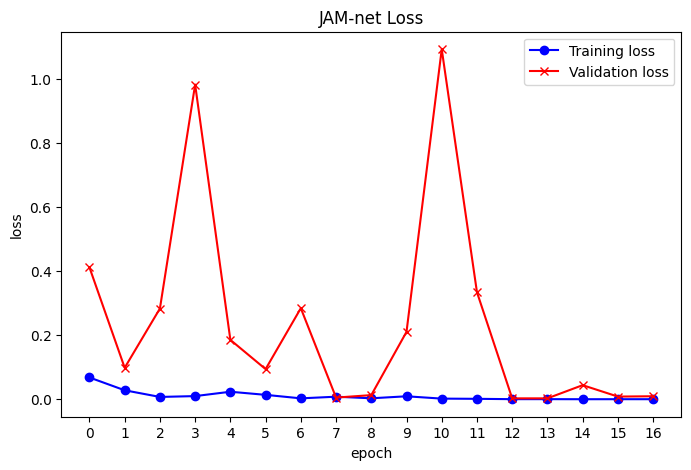

In [ ]:
my_plot(train_metrics, 'epoch', 'loss', validation_metrics, 'epoch', 'loss', title="JAM-net Loss")

**ACCURACY**

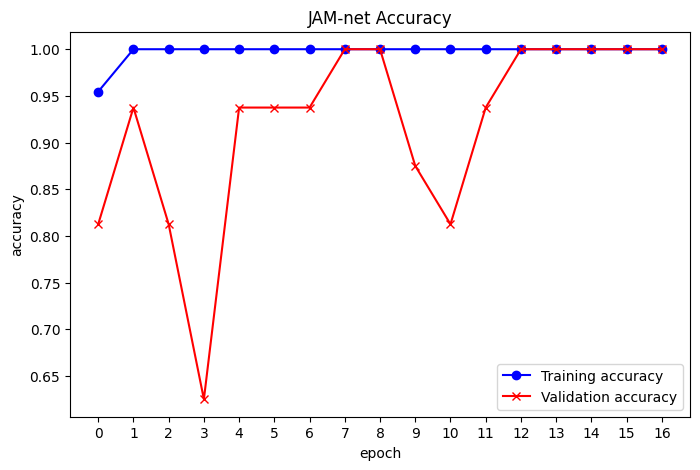

In [ ]:
my_plot(train_metrics, 'epoch', 'accuracy', validation_metrics, 'epoch', 'accuracy', title="JAM-net Accuracy")

**CONFUSION MATRIX**

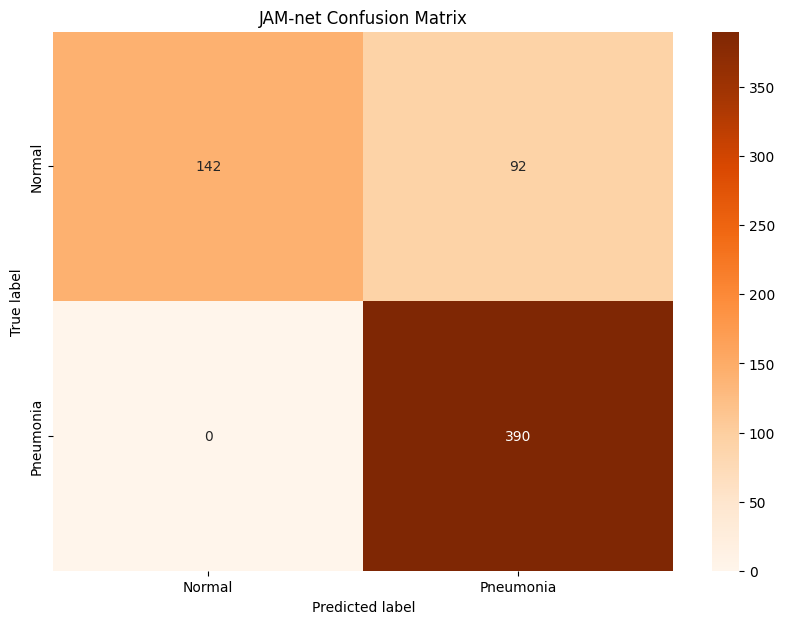

In [ ]:
class_names = ['Normal', 'Pneumonia']
cm = confusion_matrix(true_labels, predicted_labels)
plot_confusion_matrix(cm, class_names, normalize=False, title='JAM-net Confusion Matrix', cmap='Oranges')

# References
[1]  [Arshia Rehman et al.
Review on chest patogies detection systems using deep learning techniques
Artificial Intelligence Review,
2023.](https://www.researchgate.net/publication/369379105_Review_on_chest_pathogies_detection_systems_using_deep_learning_techniques)


[2] [Ziming Liu et al.
KAN: Kolmogorov-Arnold Networks
2024.](https://arxiv.org/abs/2404.19756)


[3] [Ayush Roy et al.
FA-net: A Fuzzy Attention-aided Deep Neural Network for Pneumonia Detection in Chest X-Rays
2024.](https://arxiv.org/pdf/2406.15117)

[4] [Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification](https://data.mendeley.com/datasets/rscbjbr9sj/2)

[5] [COLIN P.D. BIRCH,
A New Generalized Logistic Sigmoid Growth Equation Compared with the Richards Growth Equation,
Annals of Botany,
Volume 83, Issue 6,
1999](https://www.sciencedirect.com/science/article/pii/S0305736499908776)

